In [156]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Input, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import pandas as pd
import nltk
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from utils.data_loader import load_train_data, load_test_data


 ## Data Exploration

In [157]:
train_data, valid_data = load_train_data("data/train.csv")
loaded_test_data = load_test_data("data/test.csv", "data/test_labels.csv")
test_data = loaded_test_data[["id", "comment_text"]]
test_labels = loaded_test_data[
    [
        "toxic", "severe_toxic", "obscene",
        "threat", "insult", "identity_hate"
    ]
]

In [158]:
len(train_data), len(valid_data), len(test_data)



(143645, 15926, 63978)

In [159]:
train_data.head()



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
130060,b7bf5a6846bd456a,"""\n Oppose. WP:MOSTM, the guideline covering t...",0,0,0,0,0,0
132921,c70efd55724be549,=== I AM GLEN AND I LOVE BEING A FAG===,1,0,0,0,0,0
46589,7c7f688f129e511e,"""\n\nIf it happens it may be worth noting but ...",0,0,0,0,0,0
129843,b68d08319e5fcb14,}}\n{{WikiProject Elections and Referendums,0,0,0,0,0,0
2528,06bf9f58011ca46a,"""\n\nI posted a thread about Donny on WP:ANI ...",0,0,0,0,0,0


In [160]:
train_data["id"].head()



130060    b7bf5a6846bd456a
132921    c70efd55724be549
46589     7c7f688f129e511e
129843    b68d08319e5fcb14
2528      06bf9f58011ca46a
Name: id, dtype: object

In [161]:
train_data.isnull().values.any()



False

In [162]:
test_data.isnull().values.any()



False

In [163]:
train_data.isnull().any()



id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [164]:
test_data.isnull().any()



id              False
comment_text    False
dtype: bool

In [165]:
classes = ["toxic", "severe_toxic", "obscene",
           "threat", "insult", "identity_hate"]
train_y = train_data[classes]
train_x = train_data["comment_text"]
valid_y = valid_data[classes]
valid_x = valid_data["comment_text"]
test_x = test_data["comment_text"]

In [166]:
train_x.head()

130060    "\n Oppose. WP:MOSTM, the guideline covering t...
132921              === I AM GLEN AND I LOVE BEING A FAG===
46589     "\n\nIf it happens it may be worth noting but ...
129843          }}\n{{WikiProject Elections and Referendums
2528      "\n\nI posted a thread about Donny on WP:ANI  ...
Name: comment_text, dtype: object

In [167]:
valid_y.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
56041,0,0,0,0,0,0
147196,0,0,0,0,0,0
52015,0,0,0,0,0,0
85372,0,0,0,0,0,0
78183,0,0,0,0,0,0


In [168]:
test_x.head()

5     Thank you for understanding. I think very high...
7                      :Dear god this site is horrible.
11    "::: Somebody will invariably try to add Relig...
13    " \n\n It says it right there that it IS a typ...
14    " \n\n == Before adding a new product to the l...
Name: comment_text, dtype: object

 ## Data Preprocessing

In [169]:
max_words = 20000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(train_x))

In [170]:
tokenized_train_x = tokenizer.texts_to_sequences(train_x)
tokenized_valid_x = tokenizer.texts_to_sequences(valid_x)
tokenized_test_x = tokenizer.texts_to_sequences(test_x)

In [171]:
len(tokenized_train_x), len(tokenized_valid_x), len(tokenized_test_x)

(143645, 15926, 63978)

In [172]:
maxlen = 200
X_train = pad_sequences(tokenized_train_x, maxlen=maxlen)
X_valid = pad_sequences(tokenized_valid_x, maxlen=maxlen)
X_test = pad_sequences(tokenized_test_x, maxlen=maxlen)

In [173]:
len(X_train), len(X_valid), len(X_test)

(143645, 15926, 63978)

In [174]:
X_train[23]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [175]:
total_num_words = [len(one_comment) for one_comment in tokenized_train_x]
# total_num_words

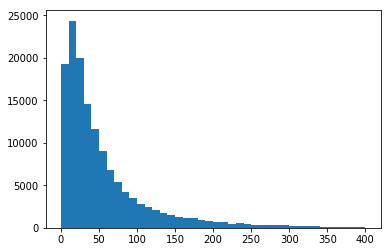

In [176]:
plt.hist(total_num_words, bins=np.arange(0, 410, 10))
plt.show()

In [177]:
train_x.iloc[0]

'"\n Oppose. WP:MOSTM, the guideline covering trademarks and brands, explicitly states not to do this. We don\'t need articles with titles like REALTOR, TIME, Se7en, Alien³, etc., despite those being their ""official"" names: these are brandings, and are designed to promote their products. But Wikipedia is not supposed to be promotional. NBC, CBS, and ABC are actual abbreviations, and are pronounced en-bee-cee, cee-bee-ess, ay-bee-cee. A reader who is truly unfamiliar with Fox in this context will end up pronouncing it ""eff-oh-ecks"".  "'

In [178]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,  1597,   114,     1,
        1210,  4308,

 ### Clean the data

In [179]:
%load_ext autoreload
%autoreload 2
from utils.preprocessing import clean

clean_train_x = clean(train_x)
clean_valid_x = clean(valid_x)
clean_test_x = clean(test_x)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time: 123.39399600028992
Time: 13.92376184463501
Time: 81.13263607025146


 ### Stopwords

In [180]:
%load_ext autoreload
%autoreload 2
from utils.preprocessing import filter_stop_words
filtered_train_x = filter_stop_words(clean_train_x)
filtered_valid_x = filter_stop_words(clean_valid_x)
filtered_test_x = filter_stop_words(clean_test_x)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(filtered_train_x))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
tokenized_train_x = tokenizer.texts_to_sequences(filtered_train_x)
tokenized_valid_x = tokenizer.texts_to_sequences(filtered_valid_x)
tokenized_test_x = tokenizer.texts_to_sequences(filtered_test_x)


In [182]:
total_num_words = [len(one_comment) for one_comment in tokenized_train_x]



 Total number of words after removing stopwords.

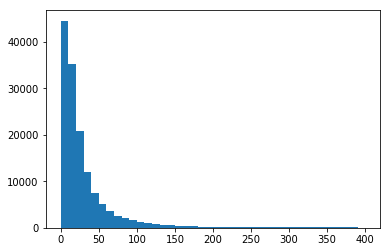

In [183]:
plt.hist(total_num_words, bins=np.arange(0, 410, 10))
plt.show()


 ### Lemmatization

In [184]:
%autoreload 2
from utils.preprocessing import lemmatize

lemmatized_train_x = lemmatize(filtered_train_x)
lemmatized_valid_x = lemmatize(filtered_valid_x)
lemmatized_test_x = lemmatize(filtered_test_x)

tokenizer.fit_on_texts(list(lemmatized_train_x))


In [185]:
tokenized_train_x = tokenizer.texts_to_sequences(lemmatized_train_x)
tokenized_valid_x = tokenizer.texts_to_sequences(lemmatized_valid_x)
tokenized_test_x = tokenizer.texts_to_sequences(lemmatized_test_x)

In [186]:
total_num_words = [len(one_comment) for one_comment in tokenized_train_x]


 Total number of words after Lemmatization + Stop words correction.

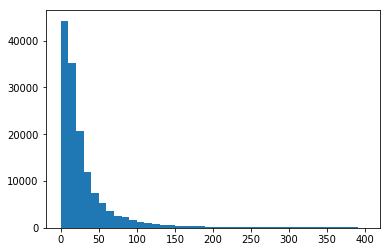

In [187]:
plt.hist(total_num_words, bins=np.arange(0, 410, 10))
plt.show()


 ### Stemming

In [188]:
%autoreload 2
from utils.preprocessing import stem

stemmed_train_x = stem(filtered_train_x)
stemmed_valid_x = stem(filtered_valid_x)
stemmed_test_x = stem(filtered_test_x)

tokenizer.fit_on_texts(list(stemmed_train_x))


In [189]:
tokenized_train_x = tokenizer.texts_to_sequences(stemmed_train_x)
tokenized_valid_x = tokenizer.texts_to_sequences(stemmed_valid_x)
tokenized_test_x = tokenizer.texts_to_sequences(stemmed_test_x)

In [190]:
total_num_words = [len(one_comment) for one_comment in tokenized_train_x]


 Total number of words after Stemming + Stop words correction.

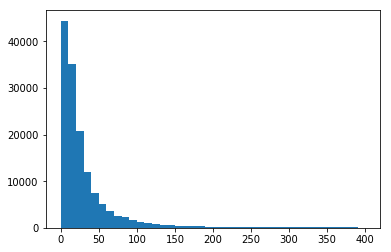

In [191]:
plt.hist(total_num_words, bins=np.arange(0, 410, 10))
plt.show()


In [192]:
print(train_x.iloc[2], "\n")
print(clean_train_x[2], "\n")
print(filtered_train_x[2], "\n")
print(lemmatized_train_x[2], "\n")
print(stemmed_train_x[2], "\n")


"

If it happens it may be worth noting but at present in my view it is more like an advert than an encyclopedic entry.  MacDui " 

 if it happens it may be worth noting but at present in my view it is more like an advert than an encyclopedic entry  macdui  

happens may worth noting present view like advert encyclopedic entry macdui 

happen may worth note present view like advert encyclopedic entry macdui 

happen may worth note present view like advert encycloped entri macdui 



In [193]:
print(valid_x.iloc[0], "\n")
print(filtered_valid_x[0], "\n")
print(lemmatized_valid_x[0], "\n")
print(stemmed_valid_x[0], "\n")


Risk factors

The role of chlamydia should be discussed, as with the increasing ectopic pregnancy rate with the increasing chlamydia incidence.   IUDs have also been linked to increased ectopic pregnancy. 

risk factors role chlamydia discussed increasing ectopic pregnancy rate increasing chlamydia incidence iuds also linked increased ectopic pregnancy 

risk factor role chlamydia discuss increase ectopic pregnancy rate increase chlamydia incidence iuds also link increase ectopic pregnancy 

risk factor role chlamydia discuss increas ectop pregnanc rate increas chlamydia incid iud also link increas ectop pregnanc 



In [194]:
print(len(train_x))

143645


In [195]:
print(len(stemmed_train_x))


143645


In [198]:
x_columns = ["comment_text"]
y_columns = ["toxic", "severe_toxic", "obscene",
           "threat", "insult", "identity_hate"]

clean_train_x_2 = pd.DataFrame(clean_train_x, columns = x_columns)
filtered_train_x_2 = pd.DataFrame(filtered_train_x, columns = x_columns)
lemmatized_train_x_2 = pd.DataFrame(lemmatized_train_x, columns = x_columns)
stemmed_train_x_2 = pd.DataFrame(stemmed_train_x, columns = x_columns)

In [201]:
clean_valid_x_2 = pd.DataFrame(clean_valid_x, columns = x_columns)
filtered_valid_x_2 = pd.DataFrame(filtered_valid_x, columns = x_columns)
lemmatized_valid_x_2 = pd.DataFrame(lemmatized_valid_x, columns = x_columns)
stemmed_valid_x_2 = pd.DataFrame(stemmed_valid_x, columns = x_columns)

In [202]:
clean_test_x_2 = pd.DataFrame(clean_test_x, columns = x_columns)
filtered_test_x_2 = pd.DataFrame(filtered_test_x, columns = x_columns)
lemmatized_test_x_2 = pd.DataFrame(lemmatized_test_x, columns = x_columns)
stemmed_test_x_2 = pd.DataFrame(stemmed_test_x, columns = x_columns)

In [203]:
import pickle

In [204]:
PATH = "./pickle"
clean_file = "cleaned_data.pickle"
lem_file = "lemmatized_data.pickle"
stem_file = "stemmed_data.pickle"

file_train = {
    "train_x": train_x,
    "clean_train_x": clean_train_x_2,
    "filtered_train_x": filtered_train_x_2, 
    "lemmatized_train_x": lemmatized_train_x_2, 
    "stemmed_train_x": stemmed_train_x_2,
    "train_y": train_y,
}

file_valid = {
    "valid_x": valid_x,
    "clean_valid_x": clean_valid_x_2,
    "filtered_valid_x": filtered_valid_x_2, 
    "lemmatized_valid_x": lemmatized_valid_x_2, 
    "stemmed_valid_x": stemmed_valid_x_2,
    "valid_y": valid_y,
}

file_test = {
    "test_x": test_x,
    "clean_test_x": clean_test_x_2,
    "filtered_test_x": filtered_test_x_2, 
    "lemmatized_test_x": lemmatized_test_x_2, 
    "stemmed_test_x": stemmed_test_x_2,
    "test_y": test_labels,
}


for file_name in file_train:
    with open("{}/{}.pickle".format(PATH, file_name), 'wb') as f:
        pickle.dump(file_train[file_name], f)

for file_name in file_valid:
    with open("{}/{}.pickle".format(PATH, file_name), 'wb') as f:
        pickle.dump(file_valid[file_name], f)
        
for file_name in file_test:
    with open("{}/{}.pickle".format(PATH, file_name), 'wb') as f:
        pickle.dump(file_test[file_name], f)